<a href="https://colab.research.google.com/github/mcnica89/MATH4060/blob/main/Connect4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Functions for Connect 4



In [53]:
import numpy as np
import random
import math
import matplotlib.pyplot  as plt

#A set of pieces is represented as 64bit integers by using the bits of the integers
#This is sometimes called a "bitboard"
#For example: the integer 0 is an empty board
#The full board is the integer whose binary rep is 1111111...1
#Integers like "2" represent a board with exactly one piece

FULL_BOARD = np.iinfo(np.uint64).max #the maximum integer corresponds to a full bitboard
EMPTY_BOARD = np.uint64(0)
N_COL = 7
N_ROW = 6
assert N_COL*N_ROW <= 64 #since we are using bitboards with 64 bits


def DrawGame(s1,s2):
   '''Use matplotlib to draw the board in text given the bitboards for player 1 and player 2'''
   pieces_s1 = BitboardToArray(s1)
   pieces_s2 = BitboardToArray(s2)

   circle1 = plt.Circle((0, 0), 0.2, color='r')
   circle2 = plt.Circle((0.5, 0.5), 0.2, color='blue')
   circle3 = plt.Circle((1, 1), 0.2, color='g', clip_on=False)

   fig, ax = plt.subplots() 
   plt.xlim(-0.5,N_COL-0.5)
   plt.ylim(-0.5,N_ROW-0.5)
   for i in range(N_ROW-1,-1,-1):
      for j in range(N_COL-1,-1,-1):
          if pieces_s1[i,j] == True:
              piece = plt.Circle((N_COL-1-j,i), 0.45, color='red')
              ax.add_patch(piece)
          elif pieces_s2[i,j] == True:
              piece = plt.Circle((N_COL-1-j,i), 0.45, color='black')
              ax.add_patch(piece)
   plt.show()


def PrintGame(s1,s2):
        '''Use text to draw the board in text given the bitboards for player 1 and player 2'''
        pieces_s1 = BitboardToArray(s1)
        pieces_s2 = BitboardToArray(s2)

        print("=="*N_COL)
        for i in range(N_ROW-1,-1,-1):
            for j in range(N_COL-1,-1,-1):
                if pieces_s1[i,j] == True:
                    print("X ",end='')
                elif pieces_s2[i,j] == True:
                    print("O ",end='')
                else:
                    print("- ",end='')
            print("")
        print("=="*N_COL)
        print(' '.join(str(i) for i in range(N_COL)))
        print("=="*N_COL)
        print("")

def BitboardToArray(s_bitboard):
    '''Convert from the bitboard reprensentation to a numpy array'''
    _iter = (char == '1' for char in np.binary_repr(s_bitboard,N_ROW*N_COL))
    return np.fromiter(_iter, dtype=bool).reshape((N_ROW,N_COL))

#array that allows easy conversion between bitboards and arrays
VAL_MATRIX = np.outer(np.power(np.uint64(2**N_COL),np.arange(N_ROW-1,-1,-1,dtype=np.uint64)),np.power(2,np.arange(N_COL-1,-1,-1,dtype=np.uint64)))
def ArrayToBitboard(s_array):
    #inputs a N_COL by N_ROW array and outputs a bitboard (a uint64 whose binary rep is the pieces)
    return np.uint64(np.sum(s_array*VAL_MATRIX))

def IsSubset(s_sub,s_super):
    '''Returns TRUE if the bitboard s_sub is a subset of s_super'''
    #Works if you put in an np array for either s_sub or s_super via broadcasting
    return np.bitwise_and(s_sub,np.bitwise_not(s_super)) == EMPTY_BOARD

def IsNotCovered(s_sub,s_super):
    '''Returns TRUE if the bitboard s_sub is entirely on things that s_super doesnt cover.'''
    #Works if you put in an np array for either s_sub or s_super via broadcasting
    return np.bitwise_and(s_sub,s_super) == EMPTY_BOARD

def CoordToBb(i,j):
    '''Returns the bitboard for the location i,j'''
    return np.uint64(2**(i*N_COL+j))
    #return np.left_shift(np.uint64(1),np.uint(i)*N_COL+np.uint(j))
    #This gives me some kind of bug about the type of i,j


COLUMN_ZERO_PIECES = np.array( [CoordToBb(y,0) for y in range(N_ROW)], dtype=np.uint64)

#A (6,7) array whose i,j entry is the bitboard at location i,j
ALL_PIECES = np.outer(COLUMN_ZERO_PIECES,np.uint64(2**np.arange(N_COL))).astype(np.uint64)

def ParrAllowedMoves(s):
    '''Calculate the allowed moves when the pieces on the board are the bitboard s'''
    #Input: s = union of all pieces on board
    #Ouput: A vector of length N_COL with the bitboard for the allowed move from that column (and 0 if no move is allowed there)
    #Works by taking the array ALL_PIECESthen finding the maximum piece in each column that is not covered
    #Works when s is actually an array by broadcasting
    return np.amax(np.multiply(ALL_PIECES[:,:,np.newaxis], IsNotCovered(ALL_PIECES[:,:,np.newaxis],s)),axis=0)

def AllowedMoves(s):
    '''Calculate the allowed moves when the pieces on the board are the bitboard s'''
    #Input: s = union of all pieces on board
    #Ouput: A vector of length N_COL with the bitboard for the allowed move from that column (and 0 if no move is allowed there)
    #Works by taking the array ALL_PIECESthen finding the maximum piece in each column that is not covered
    return np.amax(np.multiply(ALL_PIECES, IsNotCovered(ALL_PIECES,s)),axis=0)

def GenerateKinARow(k):
    '''Return an array with all the boards that contain k pieces in a line'''
    return np.array(
        [ np.sum([CoordToBb(x,y+i) for i in range(k)]) for x,y in np.ndindex(N_ROW,N_COL-k+1)] +
        [ np.sum([CoordToBb(x+i,y) for i in range(k)]) for x,y in np.ndindex(N_ROW-k+1,N_COL)] +
        [ np.sum([CoordToBb(x+i,y+i) for i in range(k)]) for x,y in np.ndindex(N_ROW-k+1,N_COL-k+1)] +
        [ np.sum([CoordToBb(x+i,N_COL-1-(y+i)) for i in range(k)]) for x,y in np.ndindex(N_ROW-k+1,N_COL-k+1)])

FOUR_IN_A_LINE = GenerateKinARow(4)
THREE_IN_A_LINE = GenerateKinARow(3)
TWO_IN_A_LINE = GenerateKinARow(2)
SINGLES = np.array( [CoordToBb(y,x) for y in range(N_ROW) for x in range(N_COL)] )
#All possible four in a row states, horiz, vertical, northeast then southeast
def HasConnectFour(s):
    '''Return whether or not the state s has a 4 in a line in it somewhere'''
    return(np.any(IsSubset(FOUR_IN_A_LINE,np.uint64(s))))

def ParrHasConnectFour(s):  
  '''Return whether or not the state s has a 4 in a line in it somewhere'''
  #Allows s to be an array by using broadcasting
  return np.any(IsSubset( FOUR_IN_A_LINE[:, np.newaxis],s),axis=0 )


# Simulation and some very basic AIs

In [54]:
def RandomAIParr(active_player_ix,game_state,allowed_moves,verbose=False):
  '''An AI that plays randomly'''
  #Parrelied over the last dimension
  random_scores = np.random.rand( N_COL, np.shape(allowed_moves)[1] )
  return np.argmax(random_scores*(allowed_moves >0), axis=0)

def RandomAI(active_player_ix,game_state,allowed_moves,verbose=False):
  '''An AI that plays randomly'''
  random_scores = np.random.randn( N_COL )**2 
  return np.argmax(random_scores, axis=0)

def HumanAI(active_player_ix,game_state,allowed_moves, verbose=True):
  '''An AI that asks the human what to do'''
  print("Which column would you like to play in")
  raw_input = input()
  play_col = np.clip(int(raw_input),0,N_ROW)
  return play_col

def SimulateGame(AIs, starting_player = 0, Verbose = True):
  '''Simulate a game of connect 4'''
  #Input: An list AIs = [AI_Red, AI_Black] with the two AIs to use
  #Ouput: An integer from {+1,0,-1} with who won: (2*player_ix_who_won - 1) or 0 for a tie
  PlayerName = ['Red','Black']
  game_state = np.zeros(2,dtype=int)
  active_player_ix = int(1 - starting_player)
  for i in range(N_COL*N_ROW):
    active_player_ix = 1 - active_player_ix
    if Verbose: DrawGame(game_state[0],game_state[1])
    allowed_moves = AllowedMoves(game_state[0]+game_state[1])
    #for m in allowed_moves:
    #  hypothetical_game_state = np.copy(game_state)
    #  hypothetical_game_state[active_player_ix] += m
    #  print(np.mean(SimulateGameParr([RandomAIParr,RandomAIParr], 1-active_player_ix, 1000, hypothetical_game_state)),end=' ')
    #print('\n')

    if np.all(allowed_moves == 0):
      if Verbose: print(f"Tie game!")
      return 0
      break
    play_col = AIs[active_player_ix](active_player_ix,game_state,allowed_moves,Verbose)
    game_state[active_player_ix] += allowed_moves[play_col]
    if HasConnectFour(game_state[active_player_ix]):
      if Verbose: print(f"The {PlayerName[active_player_ix]} player wins!")
      if Verbose: DrawGame(game_state[0],game_state[1])
      return 2*active_player_ix - 1
      break


def SimulateGameParr(AIs, starting_player, N_PARR, start_state = np.zeros(2, dtype=np.uint64), verbose=False):
  '''Simulate a game of connect 4 from a given start_state'''
  #Input: An list AIs = [AI_Red, AI_Black] with the two AIs to use
  #Ouput: The mean of {+1,0,-1} with who won: (2*player_ix_who_won - 1) or 0 for a tie averaged over the N_PARR games
  game_state = np.zeros(2,dtype=np.uint64)
  game_winner = np.zeros(N_PARR)
  game_inprogress = np.ones(N_PARR, dtype=bool)
  has_connect4 = np.logical_not(game_inprogress)
  game_state = np.transpose(np.tile(start_state, (N_PARR,1))).astype(np.uint64)
  active_player_ix = int(starting_player)
  t= 0
  while any(game_inprogress) and t < N_ROW*N_COL:
    t += 1
    active_player_ix = 1 - active_player_ix

    allowed_moves = ParrAllowedMoves(np.sum(game_state,axis=0))
    play_col = AIs[active_player_ix](active_player_ix,game_state,allowed_moves)
    game_state[active_player_ix,np.arange(N_PARR)] += allowed_moves[play_col,np.arange(N_PARR)]*game_inprogress

    has_connect4 = ParrHasConnectFour(game_state[active_player_ix,np.arange(N_PARR)])
  
    
    game_winner = np.where( np.logical_and(has_connect4,game_inprogress), 2*active_player_ix - 1, game_winner)
    game_inprogress = np.logical_and(np.logical_not(has_connect4), game_inprogress)

    if verbose:
      for j in range(N_PARR):
        print(f"Game {j}. In_Progress {game_inprogress[j]}")
        PrintGame(game_state[0,j],game_state[1,j])
    
    
  return np.mean(game_winner)

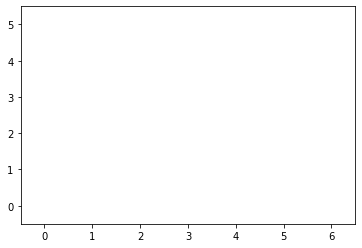

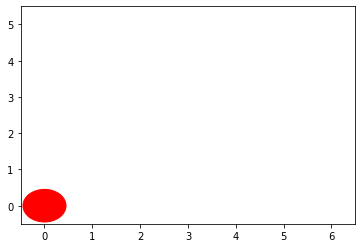

Which column would you like to play in
1


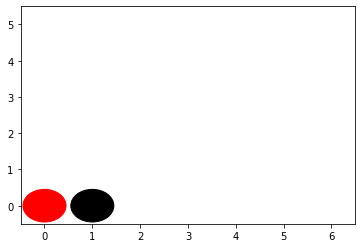

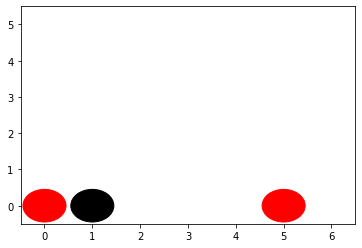

Which column would you like to play in
4


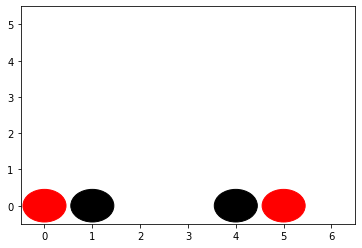

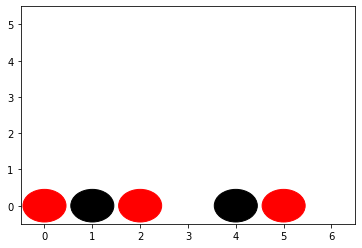

Which column would you like to play in
2


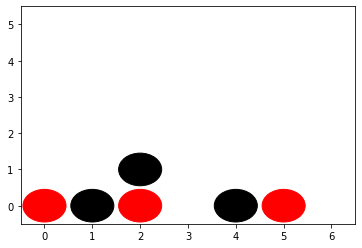

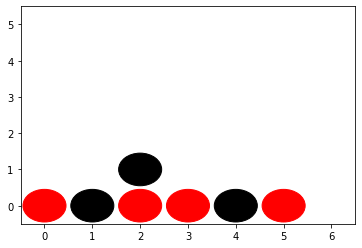

Which column would you like to play in
3


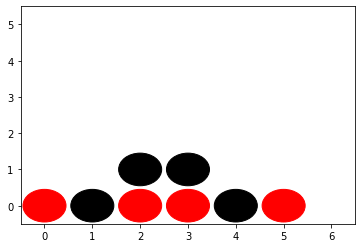

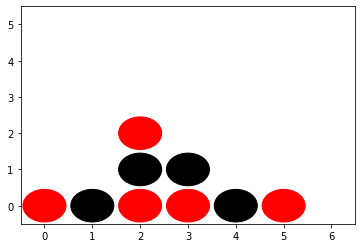

Which column would you like to play in
1


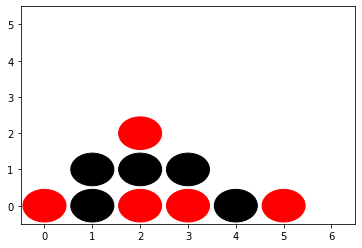

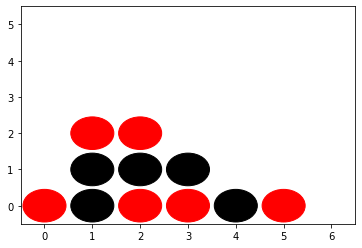

Which column would you like to play in
0
The Black player wins!


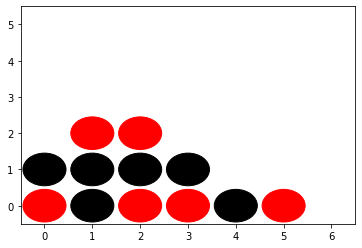

1

In [60]:
SimulateGame([RandomAI,HumanAI],Verbose=True)

# Improving the Random AI

In [56]:
np.set_printoptions(suppress=True, precision=3) 
def RandomRolloutAI(active_player_ix,game_state,allowed_moves,verbose=True):
  '''An AI that plays by running many simulations of each state using the random AI'''
  N_per_pos = 1500
  best_score = None
  best_move = None
  if verbose: print(f"{N_per_pos} simulations per option \n Avg:")
  for i in range(N_COL):
      hypothetical_game_state = np.copy(game_state)
      hypothetical_game_state[active_player_ix] += allowed_moves[i]
      score = np.mean(SimulateGameParr([RandomAIParr,RandomAIParr], 1-active_player_ix, N_per_pos, hypothetical_game_state))
      if verbose: print(f"{score:.3f}", end=' ')
      if best_score == None or (2*active_player_ix - 1)*(score - best_score)>0:
        best_score = score
        best_move = i
  if verbose: print('\n')
  return best_move

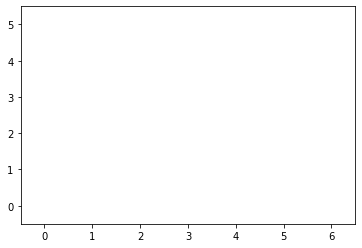

1500 simulations per option 
 Avg:
-0.213 -0.324 -0.361 -0.498 -0.352 -0.314 -0.292 



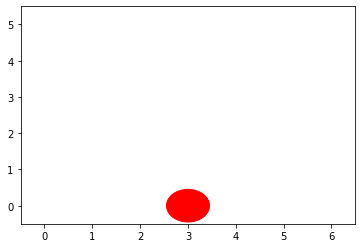

Which column would you like to play in
2


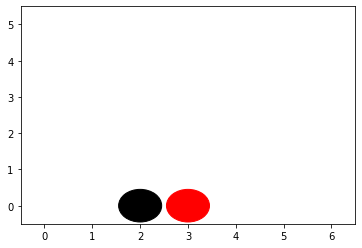

1500 simulations per option 
 Avg:
-0.319 -0.283 -0.459 -0.516 -0.429 -0.455 -0.423 



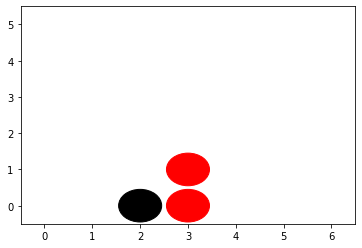

Which column would you like to play in
3


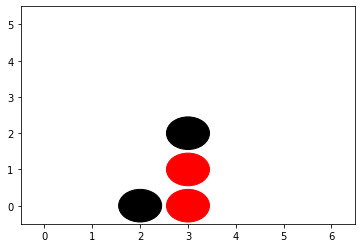

1500 simulations per option 
 Avg:
-0.293 -0.323 -0.458 -0.375 -0.391 -0.416 -0.448 



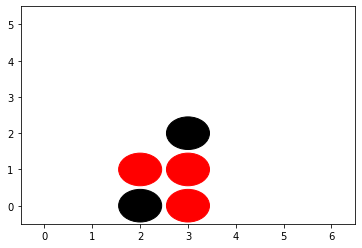

Which column would you like to play in
5


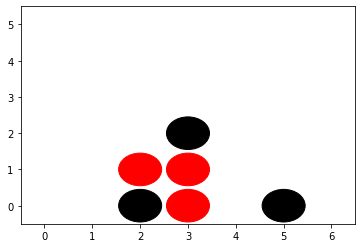

1500 simulations per option 
 Avg:
-0.335 -0.385 -0.400 -0.426 -0.327 -0.494 -0.260 



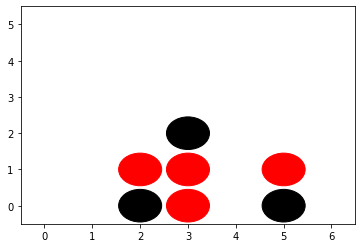

Which column would you like to play in
0


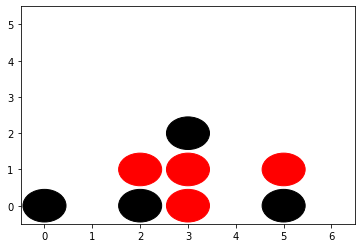

1500 simulations per option 
 Avg:
-0.621 -0.516 -0.578 -0.561 -0.560 -0.564 -0.450 



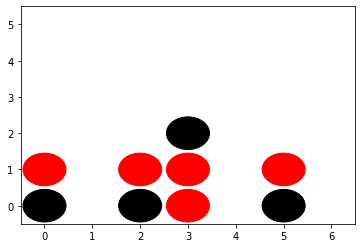

Which column would you like to play in
3


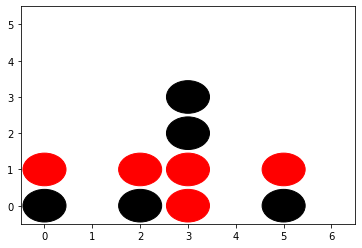

1500 simulations per option 
 Avg:
-0.487 -0.534 -0.591 -0.512 -0.492 -0.472 -0.401 



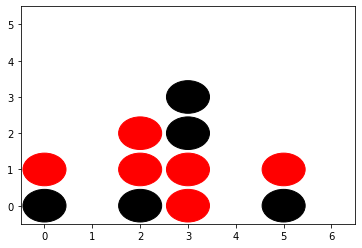

Which column would you like to play in
3


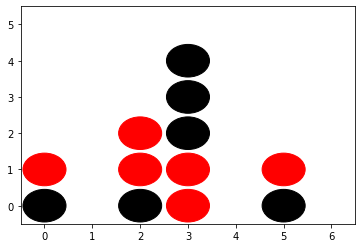

1500 simulations per option 
 Avg:
-0.243 -0.347 -0.458 -0.687 -0.328 -0.226 -0.167 



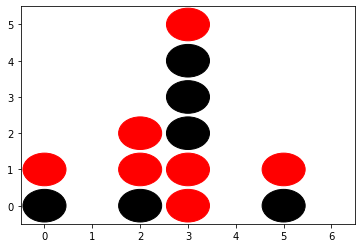

Which column would you like to play in
2


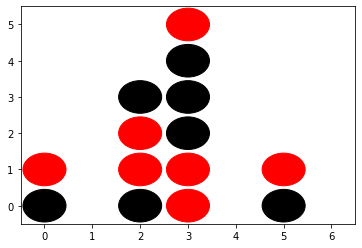

1500 simulations per option 
 Avg:
-0.421 -0.500 -0.339 -0.367 -0.285 -0.436 -0.345 



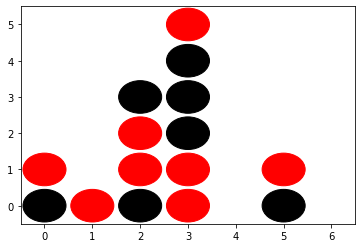

Which column would you like to play in
1


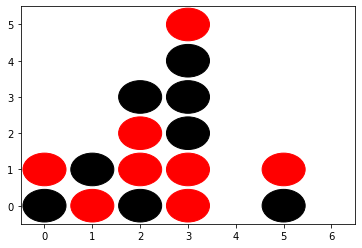

1500 simulations per option 
 Avg:
-0.308 -0.436 -0.249 -0.233 -0.239 -0.272 -0.236 



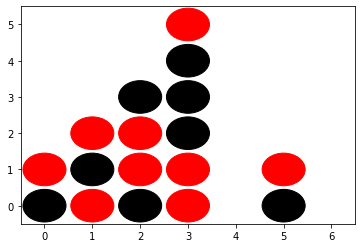

Which column would you like to play in
1


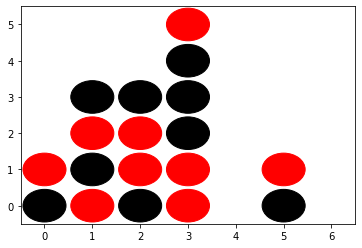

1500 simulations per option 
 Avg:
-0.132 0.007 -0.013 0.032 -0.107 -0.063 -0.012 



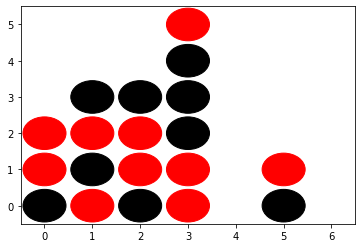

Which column would you like to play in
0
The Black player wins!


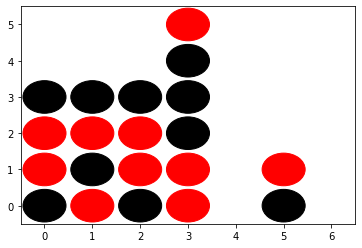

1

In [61]:
SimulateGame([RandomRolloutAI,HumanAI],Verbose=True)

In [58]:
def UCBRolloutAI(active_player_ix,game_state,allowed_moves,verbose=True):
  N = np.zeros(N_COL)
  Avg = np.zeros(N_COL)
  N_sims = 100
  N_per_sim = 100
  player_sign = (2*active_player_ix-1) #either +1 or -1 depending on if the player wants to min or max
  for i in range(N_sims):
      UCB = Avg + player_sign*2/np.sqrt(N+1)
      chosen_move_ix = np.argmax(player_sign*UCB)
      hypothetical_game_state = np.copy(game_state)
      hypothetical_game_state[active_player_ix] += allowed_moves[chosen_move_ix]
      sim_score = np.mean(SimulateGameParr([RandomAIParr,RandomAIParr], 1-active_player_ix, N_per_sim, hypothetical_game_state))
      N[chosen_move_ix] += 1
      Avg[chosen_move_ix] += (sim_score - Avg[chosen_move_ix])/N[chosen_move_ix]
    
  if verbose: print("N: ",N*N_per_sim,"\n Avg: ",Avg)
  return np.argmax(player_sign*Avg)

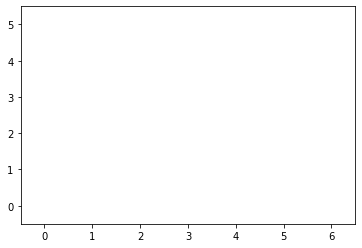

N:  [1100. 1100. 1500. 2800. 1400. 1200.  900.] 
 Avg:  [-0.313 -0.293 -0.386 -0.514 -0.365 -0.293 -0.257]


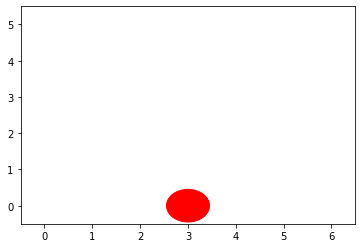

1500 simulations per option 
 Avg:
-0.161 -0.127 -0.035 0.060 -0.015 -0.109 -0.169 



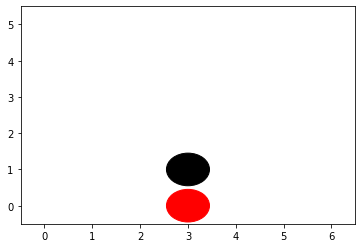

N:  [1000. 1300. 2100. 1400. 2000. 1200. 1000.] 
 Avg:  [-0.393 -0.46  -0.568 -0.459 -0.554 -0.447 -0.372]


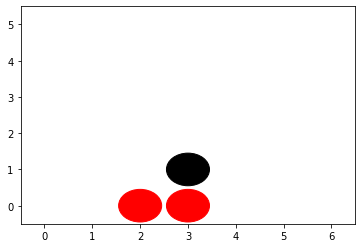

1500 simulations per option 
 Avg:
-0.072 0.116 -0.077 -0.078 0.162 -0.035 -0.239 



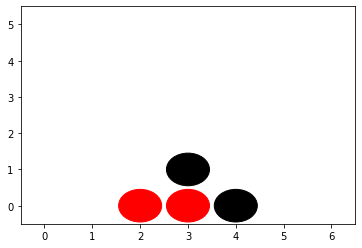

N:  [2100. 2200. 1400. 1400. 1500.  700.  700.] 
 Avg:  [-0.488 -0.491 -0.374 -0.384 -0.394 -0.19  -0.203]


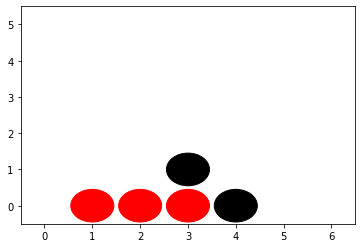

1500 simulations per option 
 Avg:
0.377 -0.049 0.025 -0.057 -0.003 -0.197 -0.240 



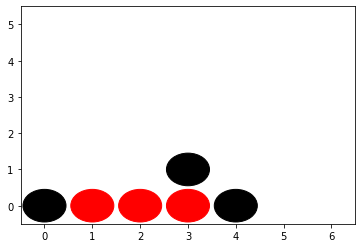

N:  [1000. 1300. 2500. 1700. 2000.  700.  800.] 
 Avg:  [ 0.036 -0.033 -0.17  -0.094 -0.136  0.169  0.1  ]


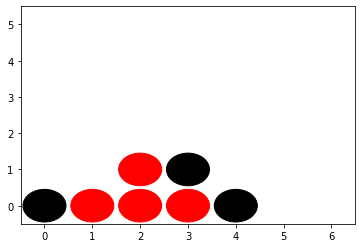

1500 simulations per option 
 Avg:
0.109 0.236 0.472 0.383 0.213 0.154 0.083 



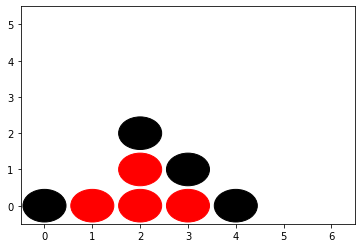

N:  [1000. 1200. 1100. 2700. 1900. 1100. 1000.] 
 Avg:  [ 0.227  0.174  0.199 -0.007  0.063  0.199  0.246]


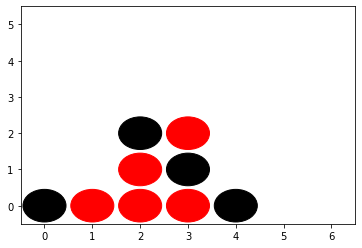

1500 simulations per option 
 Avg:
0.273 0.527 0.387 0.565 0.190 0.267 0.281 



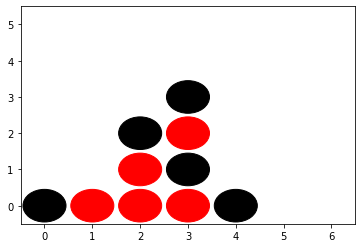

N:  [ 900. 3600. 1100.  800. 1800. 1100.  700.] 
 Avg:  [ 0.306 -0.005  0.258  0.335  0.143  0.265  0.373]


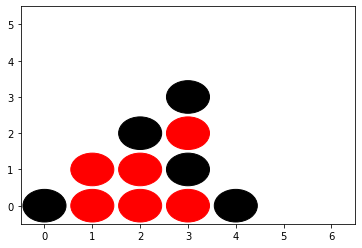

1500 simulations per option 
 Avg:
0.211 0.524 0.349 0.185 0.140 0.241 0.183 



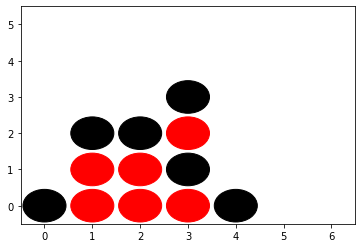

N:  [ 700. 4800.  800.  700. 1800.  800.  400.] 
 Avg:  [ 0.289 -0.167  0.214  0.277  0.006  0.251  0.458]


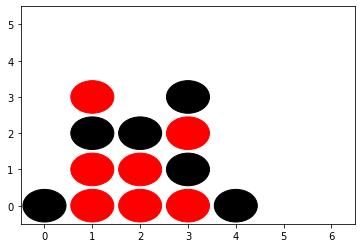

1500 simulations per option 
 Avg:
0.307 0.075 0.401 0.178 0.079 0.144 0.151 



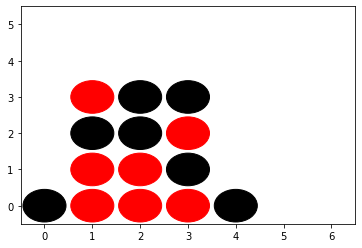

N:  [1900.  800. 2400. 1900. 1500.  700.  800.] 
 Avg:  [-0.024  0.216 -0.08  -0.037  0.035  0.233  0.191]


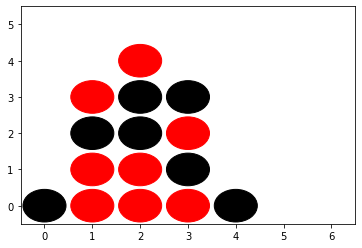

1500 simulations per option 
 Avg:
0.507 0.105 0.129 0.436 0.079 0.166 0.228 



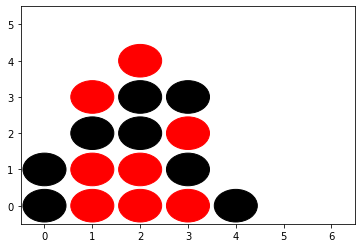

N:  [ 800.  600.  400. 6500.  700.  400.  600.] 
 Avg:  [ 0.09   0.217  0.345 -0.36   0.141  0.312  0.19 ]


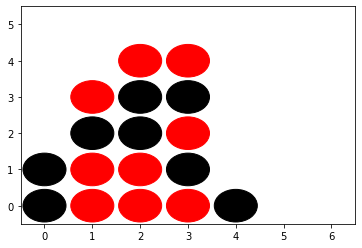

1500 simulations per option 
 Avg:
0.406 -0.073 -0.133 -0.006 -0.063 -0.103 -0.100 



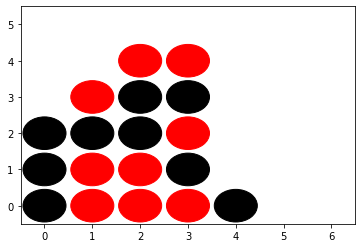

N:  [6800.  600.  600.  500.  700.  400.  400.] 
 Avg:  [-0.513  0.028  0.058  0.106  0.004  0.253  0.18 ]


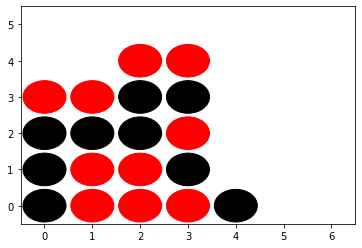

1500 simulations per option 
 Avg:
-0.239 -0.181 -0.306 -0.257 -0.271 -0.323 -0.230 



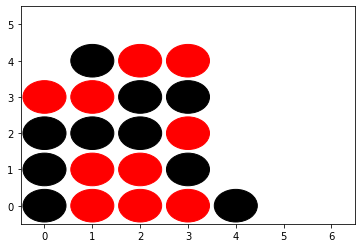

N:  [ 900. 1200. 1500. 1600. 2100.  900. 1800.] 
 Avg:  [-0.228 -0.308 -0.366 -0.383 -0.446 -0.243 -0.403]


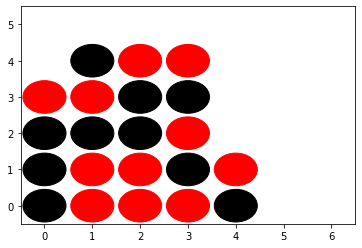

1500 simulations per option 
 Avg:
-0.399 -0.307 -0.309 -0.286 -0.181 -0.280 -0.223 



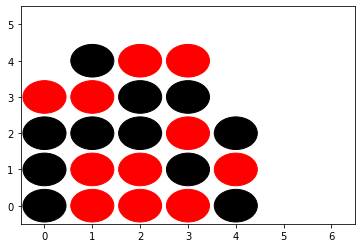

N:  [ 400.  600.  600.  800. 6400.  500.  700.] 
 Avg:  [-0.332 -0.467 -0.475 -0.555 -1.    -0.356 -0.519]
The Red player wins!


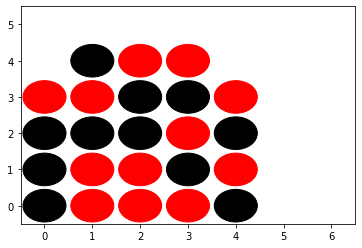

-1

In [63]:
SimulateGame([UCBRolloutAI,RandomRolloutAI],Verbose=True)